# Imports

In [1]:
import gensim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
from nltk.stem.porter import PorterStemmer
from string import  ascii_lowercase
import nltk #TODO: figure out how to notify sagiv about new libraries
nltk.download("stopwords")
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 
from torch.nn.utils.rnn import pad_sequence
from sklearn.model_selection import train_test_split
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
import time
from sklearn.metrics import roc_auc_score, roc_curve, auc

from torch.nn.utils.rnn import pad_sequence
from torch.nn.utils.rnn import pack_padded_sequence
from torch.nn.utils.rnn import pad_packed_sequence

In [ ]:
data_path = 'projectData/'
models_path = 'models/'
tb_dir = 'tbs/'

In [ ]:
%tensorboard --logdir tbs --port 6007

UsageError: Line magic function `%tensorboard` not found.


## import word2vec matrix

In [ ]:
WORD_2_VEC_PATH = models_path+'word2vec.model'

In [ ]:
model = gensim.models.Word2Vec.load(WORD_2_VEC_PATH)
word2vec_matrix = torch.FloatTensor(model.wv.vectors)

# Load Data

In [ ]:
raw_data = pd.read_csv(data_path+'dataset_raw.csv')

In [ ]:
mini_raw_data = raw_data.sample(10000)

In [ ]:
preprocessed_data =  mini_raw_data['review'].apply(gensim.utils.simple_preprocess)

In [ ]:
stemmer = PorterStemmer()
stop_words = set(stopwords.words('english'))
allowed_symbols = set(l for l in ascii_lowercase)

In [ ]:
def preprocess_sentence(sentence):
    output_sentence = []
    for word in sentence:
        word = word.lower() #lower case the word
        if word not in stop_words:  #ignore stop words
            word = ''.join([i for i in word if i in allowed_symbols]) #remove characters which are not in allowed symbols
            word = stemmer.stem(word) #stemming
            if len(word) >1 : #discard words with length<=1
                output_sentence.append(word)
    return output_sentence
    

In [ ]:
preprocessed_data

22852    [this, was, one, of, the, worst, films, have, ...
33474    [this, is, not, commentary, on, the, actual, m...
29582    [for, die, hard, judy, garland, fans, only, th...
11218    [saw, this, movie, with, my, dad, must, have, ...
28498    [oh, it, the, movie, thought, waited, too, lon...
                               ...                        
8002     [the, essence, of, this, film, falls, on, judg...
28916    [we, actually, watched, this, twice, in, the, ...
10794    [as, part, of, our, late, vocabulary, we, well...
36878    [have, an, awful, pan, and, scan, videotape, o...
35241    [the, biggest, one, that, bugs, the, hell, out...
Name: review, Length: 10000, dtype: object

In [ ]:
#TODO: Move to notebook for preprocessing and save output
preprocessed_data = preprocessed_data.apply(preprocess_sentence, convert_dtype=True)

# Train Word2Vec on our New Data

In [ ]:
# we use default embedding size of 100
model = gensim.models.Word2Vec(
    vector_size = 50,
    window = 5,
    min_count =5,
    workers= 4
)

In [ ]:
model.build_vocab(preprocessed_data)

In [ ]:
model.epochs = 30

In [ ]:
model.train(preprocessed_data, total_examples=model.corpus_count, epochs = model.epochs,)

(32266492, 36269100)

In [ ]:
weights = torch.FloatTensor(model.wv.vectors)

In [ ]:
weights.shape

torch.Size([13162, 50])

In [ ]:
def check_of_word_in_word2vec(sentence):
    """
    Function that ignores word with low frequency, to avoid keyerrors
    returns sentences without words oov
    """
    output_sentence = []
    for word in sentence:
        try:
            dummy = model.wv.get_index(word)
            output_sentence.append(word)

        except KeyError:
           continue
    return output_sentence

preprocessed_data = preprocessed_data.apply(check_of_word_in_word2vec)

In [ ]:
def tokenize(review):
    return torch.LongTensor([model.wv.get_index(word) for word in review])

In [ ]:
X = preprocessed_data.apply(lambda x: tokenize(x))

In [ ]:
X

22852    [tensor(3), tensor(166), tensor(2), tensor(54)...
33474    [tensor(1298), tensor(65), tensor(1), tensor(1...
29582    [tensor(258), tensor(174), tensor(3316), tenso...
11218    [tensor(134), tensor(1), tensor(1140), tensor(...
28498    [tensor(380), tensor(1), tensor(94), tensor(38...
                               ...                        
8002     [tensor(3096), tensor(2), tensor(265), tensor(...
28916    [tensor(65), tensor(11), tensor(1364), tensor(...
10794    [tensor(61), tensor(421), tensor(7170), tensor...
36878    [tensor(275), tensor(2189), tensor(5107), tens...
35241    [tensor(1021), tensor(3), tensor(1575), tensor...
Name: review, Length: 10000, dtype: object

In [ ]:
y = torch.tensor(mini_raw_data['label'].values)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=.25,
                                                    random_state=42)

# Define Our Model

## Equations of the LSTM cell:

![lstm.png](lstmeq.jpeg)
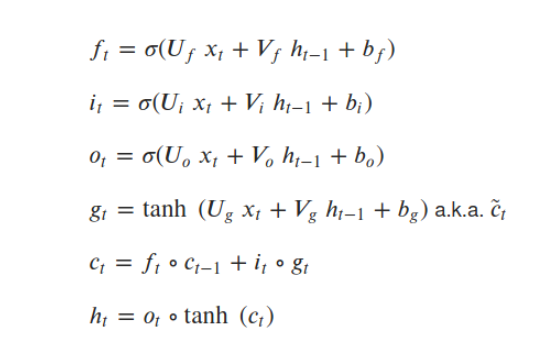

In [ ]:
class new_LSTM(nn.Module):
    def __init__(self, input_sz: int, hidden_sz: int, label_sz: int):
        super().__init__()
        self.input_size = input_sz
        self.hidden_size = hidden_sz
        self.label_size = label_sz

        self.U_i = nn.Parameter(torch.Tensor(input_sz, hidden_sz))
        self.V_i = nn.Parameter(torch.Tensor(hidden_sz, hidden_sz))
        self.b_i = nn.Parameter(torch.Tensor(hidden_sz))

        self.U_f = nn.Parameter(torch.Tensor(input_sz, hidden_sz))
        self.V_f = nn.Parameter(torch.Tensor(hidden_sz, hidden_sz))
        self.b_f = nn.Parameter(torch.Tensor(hidden_sz))

        self.U_c = nn.Parameter(torch.Tensor(input_sz, hidden_sz))
        self.V_c = nn.Parameter(torch.Tensor(hidden_sz, hidden_sz))
        self.b_c = nn.Parameter(torch.Tensor(hidden_sz))

        self.U_o = nn.Parameter(torch.Tensor(input_sz, hidden_sz))
        self.V_o = nn.Parameter(torch.Tensor(hidden_sz, hidden_sz))
        self.b_o = nn.Parameter(torch.Tensor(hidden_sz))

        self.hidden2label = nn.Parameter(torch.Tensor(hidden_sz, label_sz))
        
        self.init_weights()
    
    def init_weights(self):
            stdv = 1.0 / math.sqrt(self.hidden_size)
            for weight in self.parameters():
                weight.data.uniform_(-stdv, stdv)
                
    
    def forward(self,
                    x,
                    init_states=None):

            """
            assumes x.shape represents (batch_size, sequence_size, input_size)
            """
            seq_sz, embeded_sz = x.size()
            
            if init_states is None:
                h_t, c_t = (
                    torch.zeros(self.hidden_size).to(x.device),
                    torch.zeros(self.hidden_size).to(x.device),
                )
            else:
                h_t, c_t = init_states

            #loop over all words in sequence
            
            for t in range(seq_sz):
                x_t = x[t]
                i_t = torch.sigmoid(x_t @ self.U_i + h_t @ self.V_i + self.b_i)
                f_t = torch.sigmoid(x_t @ self.U_f + h_t @ self.V_f + self.b_f)
                g_t = torch.tanh(x_t @ self.U_c + h_t @ self.V_c + self.b_c)
                o_t = torch.sigmoid(x_t @ self.U_o + h_t @ self.V_o + self.b_o)
                c_t = f_t * c_t + i_t * g_t
                h_t = o_t * torch.tanh(c_t)
                    
                
                # last word:
                if t==seq_sz-1:
                    y_pred = torch.sigmoid(h_t @ self.hidden2label)
            
            return  y_pred

In [ ]:
class Net(nn.Module):
    def __init__(self,input_sz: int, hidden_sz: int, label_sz: int, embedding_weights):
        super().__init__()
        self.embedding = nn.Embedding.from_pretrained(embedding_weights)
        self.lstm = new_LSTM(input_sz, hidden_sz, label_sz)
    
    def forward(self,x):
        x_embeded = self.embedding(x)
        pred = self.lstm(x_embeded)
        return pred

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#TODO: dynamic embedding size
classifier = Net(50, 5, 1, weights).to(device)
optimizer = optim.Adam(classifier.parameters(), lr=0.1)
criterion = nn.BCELoss()
epochs = 20

In [ ]:
if torch.cuda.is_available():
    print(f'using: {torch.cuda.get_device_name(0)}')
else:
    print('using cpu')

using cpu


In [ ]:
y_train[0].view(1)

tensor([0])

# Training Loop

In [ ]:
def run_model_loop(X_train, X_test, y_train, y_test, classifier, epochs, criterion, optimizer, tb_dirname):
    train_loss_list = []
    test_loss_list = []
    train_auc_list=[]
    test_auc_list=[]

    writer = SummaryWriter(log_dir=f'{tb_dir}/{tb_dirname}_{time.time()}')
    i = 0
    for e in range(epochs):
        train_labels_list = []
        train_prediction_list = []
        test_labels_list = []
        test_prediction_list = []
        
        running_loss = 0
        classifier.train()
        optimizer.zero_grad()
        print(f'epoch {i} started')
        for i, review in enumerate(X_train):
            label= y_train[i].view(1)
            review, label = review.to(device), label.to(device)
            pred = classifier(review)
            pred = pred.to(torch.float)
            label = label.to(torch.float)
            loss = criterion(pred, label)
            running_loss+=loss.item()
            train_prediction_list.append(pred)
            train_labels_list.append(label)
            if i != 0 and i%32 == 0:
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()
        epoch_train_loss = running_loss/len(X_train)
        train_loss_list.append(epoch_train_loss)
        print(train_loss_list)
        #fpr_t, tpr_t, thresholds_t = roc_curve(np.array(train_labels_list), np.array(train_prediction_list))
        #train_auc = auc(fpr_t, tpr_t)
        #train_auc_list.append(train_auc)    
        
        test_loss = 0
        classifier.eval()
        # we dont need to update weights, so we define no_grad() to save memory
        with torch.no_grad():
            for i, review in enumerate(X_test):
                label= y_test[i].view(1)
                review, label = review.to(device), label.to(device)
                test_pred = classifier(review)
                test_pred = test_pred.to(torch.float)
                label = label.to(torch.float)
                test_loss+=criterion(test_pred, label)
                test_prediction_list.append(test_pred)
                test_labels_list.append(label)
        epoch_test_loss = test_loss/len(X_test)
        test_loss_list.append(epoch_test_loss)
        #fpr_v, tpr_v, thresholds_v = roc_curve(np.array(test_labels_list),np.array(test_prediction_list))
        #test_auc = auc(fpr_v, tpr_v)
        #test_auc_list.append(test_auc)
        
        #Tensorboard documentation
        #loss
        writer.add_scalar(tag='loss/train', scalar_value=epoch_train_loss, global_step=e)
        writer.add_scalar(tag='loss/test', scalar_value=epoch_test_loss, global_step=e)
        #auc
        #writer.add_scalar(tag='auc/train', scalar_value=train_auc, global_step=e)
        #writer.add_scalar(tag='auc/test', scalar_value=test_auc, global_step=e)

    return {'train_loss':train_loss_list,
            'train_auc':train_auc_list,
            'test_auc':test_auc_list,
            'test_loss':test_loss_list
            }

In [69]:
lstm_run = run_model_loop(X_train,X_test,y_train, y_test, classifier,epochs,criterion,optimizer,'lr_pytorch')

epoch 0 started


# Loss and Auc Plots

In [ ]:
#Loss vs epochs graph 
plt.figure(figsize=(20,10))
plt.plot(lstm_run['train_loss'], label = 'net train loss')
plt.legend(frameon = False)

In [ ]:
#Loss vs epochs graph 
plt.figure(figsize=(20,10))
plt.plot(lstm_run['test_loss'], label = 'net test loss')
plt.legend(frameon = False)

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(fpr_v, tpr_v, lw=2, alpha=0.3, label='ROC fold')
# ROC GRAPH
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC of ' + 'our model'.split("(")[0] + ' model')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.legend(loc = "lower right")
plt.show() 